In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import cProfile
from simplec import Simulation


from models.building.building import BuildingModel
from models.heat_pump.heat_pump import HeatPumpEventBased, HeatPumpWControlEventBased
from models.hysteresis_controller.hysteresis_controller import HystController
from models.weather.weather import SynproWeather
from models.demand.loadprofilegenerator import Household
from models.smart_meter.smart_meter import SmartMeter
from models.electricity_grid.electricity_grid_simple import Grid
from models.gridoperator.gridoperator import GridOperator
from models.battery_storage.battery_storage import BatteryStorage
from models.pv.pv import SynproPV

In [2]:
sim = Simulation()

# Weather
weather    = SynproWeather(name='weather')
sim.add_model(weather,    watch_values=['T_amb', 'I_dir', 'I_dif'])

# Grid
grid = Grid('grid')
sim.add_model(grid, watch_values=['P_substation'])

# Gridoperator
gridoperator = GridOperator(name='grid_operator')
sim.add_model(gridoperator) # , watch_values=['df_P_day'])

###########
# Building
###########
# Building Envelope
building   = BuildingModel(name='building_envelope', count_of_dot_Q_int=2)
sim.add_model(building,   watch_values=['T_building'])
sim.connect(weather, building, 'T_amb', 'I_dir', 'I_dif', 'I_s', 'I_w', 'I_n', 'I_e')
sim.connect_constant(0.0, building, 'dot_Q_cool')

pv = SynproPV('pv', 20_000)  #  TODO: Replace PV model!
sim.add_model(pv, watch_values=['P_pv'])

# Heat Pump
heatpump   = HeatPumpWControlEventBased(
    'heatpump',
    eta=0.4,
    dot_Q_hp_nom=15000,
    P_el_max=4000,
    P_el_min=1000
    )
sim.add_model(heatpump,   watch_values=['P_el', 'dot_Q_hp'])
sim.connect(heatpump, building, ('dot_Q_hp', 'dot_Q_heat'))
sim.connect(weather, heatpump, ('T_amb', 'T_source'))
sim.connect(building, heatpump, ('T_building', 'T_sink'), time_shifted=True, init_values={'T_building': 21})

# HP Controller
controller = HystController(
    'controller',
    hyst=2.
    )
sim.add_model(controller)
sim.connect(controller, heatpump, ('state', 'state'), triggers=['state'])
sim.connect(building, controller, ('T_building', 'T_is'), time_shifted=True, init_values={'T_building': 21})

# Battery storage
battery_storage = BatteryStorage(
    name = 'battery_storage_1',
    E_max               = 20000*3600, # J
    E_min               = 0*3600, # J
    E_0                 = 10000*3600, # J
    P_max_charge        = 20000, # W
    P_max_discharge     = 20000, # W
    eta_charge          = 0.9,
    eta_discharge       = 0.9,
    self_discharge_rate = 0, # 1/s
)
sim.add_model(battery_storage, watch_values=['P_set', 'P_grid', 'E'])
# sim.connect_constant(2000, battery_storage, 'P_set') # Mock controller

# Smart meter
smartmeter_building = SmartMeter(name='smartmeter_building')
sim.add_model(smartmeter_building)
sim.connect(pv, smartmeter_building, ('P_pv', 'P_'))
sim.connect(heatpump, smartmeter_building, ('P_el', 'P_'))
sim.connect(battery_storage, smartmeter_building, ('P_grid', 'P_'))
sim.connect(smartmeter_building, grid, ('P_grid', 'P_'))
gridoperator.register_smartmeter(smartmeter_building)
sim.connect_nothing(smartmeter_building, gridoperator)

##############
# Appartments
##############

###############
# Appartment 1
###############
appartment1 = Household(
    name='appartment_1',
    lpg_dir='data/loadprofilegenerator/CHR41 Family with 3 children, both at work/Results'
    )
sim.add_model(appartment1, 
              watch_values=['P_el', 'dot_m_ww', 'dot_Q_gain_int']
              )
sim.connect(appartment1, building, ('dot_Q_gain_int', 'dot_Q_int_0'))

# Smart meter
smartmeter_apprtmnt1 = SmartMeter(name='smartmeter_appartment_1')
sim.add_model(smartmeter_apprtmnt1)
sim.connect(appartment1, smartmeter_apprtmnt1, ('P_el', 'P_'))
sim.connect(smartmeter_apprtmnt1, grid, ('P_grid', 'P_'))
gridoperator.register_smartmeter(smartmeter_apprtmnt1)
sim.connect_nothing(smartmeter_apprtmnt1, gridoperator)

###############
# Appartment 2   # TODO: create and change profile
###############
appartment2 = Household(
    name='appartment_2',
    lpg_dir='data/loadprofilegenerator/CHR41 Family with 3 children, both at work/Results'
    )
sim.add_model(appartment2, 
              watch_values=['P_el', 'dot_m_ww', 'dot_Q_gain_int']
              )
sim.connect(appartment2, building, ('dot_Q_gain_int', 'dot_Q_int_1'))

# Smart meter
smartmeter_apprtmnt2 = SmartMeter(name='smartmeter_appartment_2')
sim.add_model(smartmeter_apprtmnt2)
sim.connect(appartment2, smartmeter_apprtmnt2, ('P_el', 'P_'))
sim.connect(smartmeter_apprtmnt2, grid, ('P_grid', 'P_'))
gridoperator.register_smartmeter(smartmeter_apprtmnt2)
sim.connect_nothing(smartmeter_apprtmnt2, gridoperator)

In [3]:
# Controller Setup
from models.mp_controller.mp_controller import MPController
from models.mp_controller.opt_models.battery_storage import BES_MILP_model
from models.mp_controller.opt_models.energy_community import EC__Residual_Load_MILP_model
from models.mp_controller.forcasting import Forcasting

mp_contr = MPController(name='MPC', n_periods=96, delta_t=60*15, return_forcast=True)

############
# EC
############
## Model of EC
milp_ec  = EC__Residual_Load_MILP_model()
mp_contr.add_model(milp_ec)

## Forcast for EC
ec_forcast = Forcasting('persistence_residual_load', init_val=0)
mp_contr.add_forcaster(ec_forcast, milp_ec, 'P_resid_ec')


##############
# BES
##############
milp_bes = BES_MILP_model(
    name='bes',
    E_min=0,
    E_max=20_000*3600, # J
    P_max_cha=2000, # W
    P_max_dis=2000, # W
    eta_cha=0.9, # 
    eta_dis=0.9 # 
    )
mp_contr.add_model(milp_bes)

sim.add_model(mp_contr, watch_values=['P_tot', 'E_BES_0_of_bes', 'P_el_of_bes']) # , watch_heavy=['P_resid_ec_of_EC'])

sim.connect(battery_storage, mp_contr, ('E', 'E_BES_0_of_bes'), ('P_grid', 'P_flex_'))
sim.connect(grid, mp_contr, ('P_substation', 'P_tot'))

sim.connect(mp_contr, battery_storage, ('P_el_of_bes', 'P_set'), time_shifted=True, init_values={'P_el_of_bes': 0})

In [4]:
import cProfile

In [5]:
times = pd.date_range('2021-01-01 00:00:00', '2021-01-02 00:00:00', freq='1min', tz='Europe/Berlin')  # 'UTC+01:00')

sim.run(times)
# cProfile.run('sim.run(times)', f'restats_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}.prof')

Progress: 1441Steps [00:04, 298.33Steps/s]


In [6]:
# import pickle
# sim.df.to_pickle('results_df_simple_scenario_from_210101_to_210601.plk')
# with open('results_data_simple_scenario_from_210101_to_210601.plk', 'wb') as f:
#     pickle.dump(sim.data, f)


In [7]:
# Attempt to convert df to numeric
df = sim.df
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(df[col])
df = df.ffill()
df.head()

model                       weather                     grid  \
i/o                         outputs                  outputs   
attribute                     T_amb I_dir I_dif P_substation   
2021-01-01 00:00:00+01:00  0.800000   0.0   0.0    98.337926   
2021-01-01 00:01:00+01:00  0.811667   0.0   0.0  2551.722874   
2021-01-01 00:02:00+01:00  0.823333   0.0   0.0  2551.310231   
2021-01-01 00:03:00+01:00  0.835000   0.0   0.0  2550.897829   
2021-01-01 00:04:00+01:00  0.846667   0.0   0.0  2550.485667   

model                     building_envelope      pv     heatpump           \
i/o                                 outputs outputs      outputs            
attribute                        T_building    P_pv         P_el dot_Q_hp   
2021-01-01 00:00:00+01:00         19.989936    -0.0     0.000000      0.0   
2021-01-01 00:01:00+01:00         19.998968    -0.0  2453.384948  15000.0   
2021-01-01 00:02:00+01:00         20.008002    -0.0  2452.972305  15000.0   
2021-01-01 00:03:00+01:00         20.017037    -0.0  2452.559903  15000.0   
2021-01-01 00:04:00+01:00         20.026074    -0.0  2452.147741  15000.0   

model                     battery_storage_1                     appartment_1  \
i/o                                  inputs outputs                  outputs   
attribute                             P_set  P_grid           E         P_el   
2021-01-01 00:00:00+01:00               0.0     0.0  36000000.0    49.168963   
2021-01-01 00:01:00+01:00               0.0     0.0  36000000.0    49.168963   
2021-01-01 00:02:00+01:00               0.0     0.0  36000000.0    49.168963   
2021-01-01 00:03:00+01:00               0.0     0.0  36000000.0    49.168963   
2021-01-01 00:04:00+01:00               0.0     0.0  36000000.0    49.168963   

model                                             appartment_2           \
i/o                                                    outputs            
attribute                 dot_m_ww dot_Q_gain_int         P_el dot_m_ww   
2021-01-01 00:00:00+01:00      0.0      48.585394    49.168963      0.0   
2021-01-01 00:01:00+01:00      0.0      48.585394    49.168963      0.0   
2021-01-01 00:02:00+01:00      0.0      48.585394    49.168963      0.0   
2021-01-01 00:03:00+01:00      0.0      48.585394    49.168963      0.0   
2021-01-01 00:04:00+01:00      0.0      48.585394    49.168963      0.0   

model                                           MPC                             
i/o                                          inputs                    outputs  
attribute                 dot_Q_gain_int      P_tot E_BES_0_of_bes P_el_of_bes  
2021-01-01 00:00:00+01:00      48.585394  98.337926     36000000.0         0.0  
2021-01-01 00:01:00+01:00      48.585394  98.337926     36000000.0         0.0  
2021-01-01 00:02:00+01:00      48.585394  98.337926     36000000.0         0.0  
2021-01-01 00:03:00+01:00      48.585394  98.337926     36000000.0         0.0  
2021-01-01 00:04:00+01:00      48.585394  98.337926     36000000.0         0.0

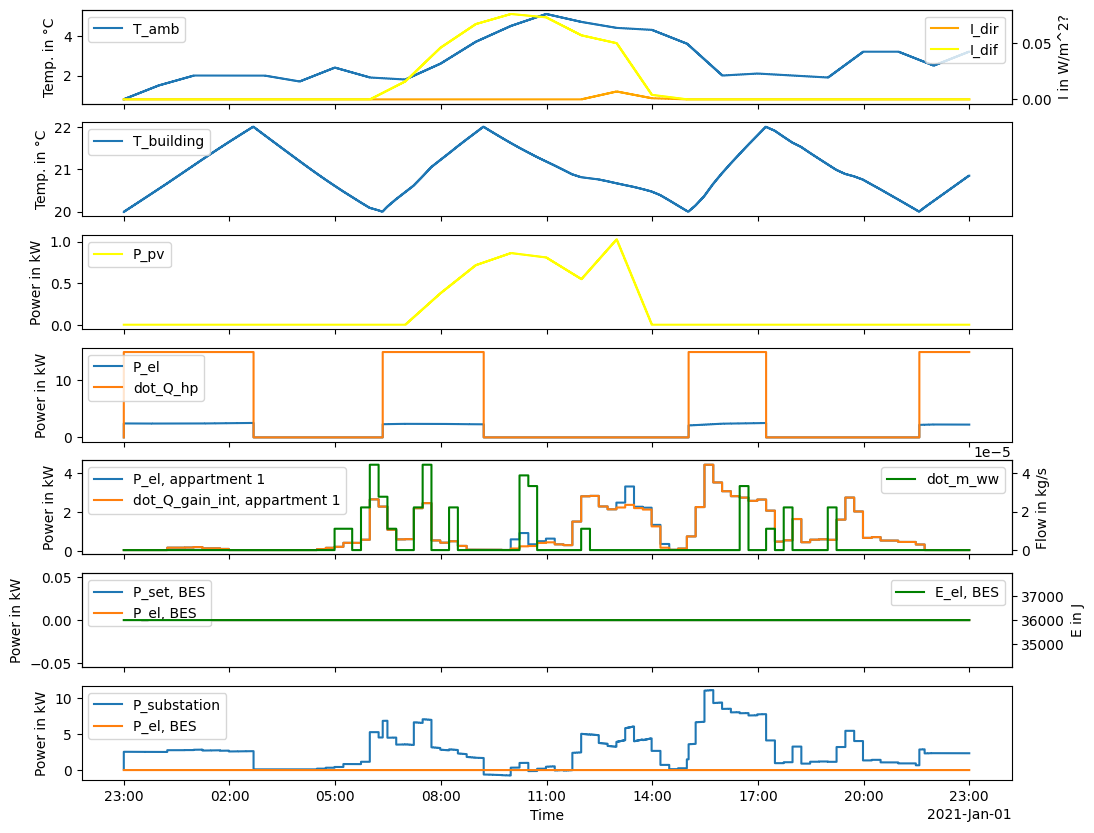

In [8]:
dtindex = df.index 

fig, axs = plt.subplots(7, sharex=True, figsize=(12, 10))
i = -1
# Weather
i += 1
ax = axs[i]
ax.plot(dtindex, df.loc[:, ('weather', 'outputs', 'T_amb')], label='T_amb', drawstyle='steps')
ax.legend(loc='upper left')
ax.set_ylabel('Temp. in °C')

tax = ax.twinx()
tax.plot(dtindex, df.loc[:, ('weather', 'outputs', 'I_dir')]/1000, label='I_dir', drawstyle='steps', color='orange')
tax.plot(dtindex, df.loc[:, ('weather', 'outputs', 'I_dif')]/1000, label='I_dif', drawstyle='steps', color='yellow')
tax.legend(loc='upper right')
tax.set_ylabel('I in W/m^2?')

# Building Temperature
i += 1
ax = axs[1]
ax.plot(dtindex, df.loc[:, ('building_envelope', 'outputs', 'T_building')], label='T_building', drawstyle='steps')
ax.legend(loc='upper left')
ax.set_ylabel('Temp. in °C')

# PV
i += 1
ax = axs[i]
ax.plot(dtindex, -df.loc[:, ('pv', 'outputs', 'P_pv')]/1000, label='P_pv', drawstyle='steps', color='yellow')
ax.legend(loc='upper left')
ax.set_ylabel('Power in kW')

# Heat Pump
i += 1
ax = axs[i]
ax.plot(dtindex, df.loc[:, ('heatpump', 'outputs', 'P_el')]/1000, label='P_el', drawstyle='steps')
ax.plot(dtindex, df.loc[:, ('heatpump', 'outputs', 'dot_Q_hp')]/1000, label='dot_Q_hp', drawstyle='steps')
ax.legend(loc='upper left')
ax.set_ylabel('Power in kW')

# Appartment 1
i += 1
ax = axs[i]
ax.plot(dtindex, df.loc[:, ('appartment_1', 'outputs', 'P_el')]/1000, label='P_el, appartment 1', drawstyle='steps')
ax.plot(dtindex, df.loc[:, ('appartment_1', 'outputs', 'dot_Q_gain_int')]/1000, label='dot_Q_gain_int, appartment 1', drawstyle='steps')
ax.legend(loc='upper left')
ax.set_ylabel('Power in kW')

tax = ax.twinx()
tax.plot(dtindex, df.loc[:, ('appartment_1', 'outputs', 'dot_m_ww')]/1000, label='dot_m_ww', drawstyle='steps', color='green')
tax.legend(loc='upper right')
tax.set_ylabel('Flow in kg/s')

# # Appartment 2
# i += 1
# ax = axs[i]
# ax.plot(dtindex, df.loc[:, ('appartment_2', 'outputs', 'P_el')]/1000, label='P_el, appartment 1', drawstyle='steps')
# ax.plot(dtindex, df.loc[:, ('appartment_2', 'outputs', 'dot_Q_gain_int')]/1000, label='dot_Q_gain_int, appartment 1', drawstyle='steps')
# ax.legend(loc='upper left')
# ax.set_ylabel('Power in kW')

# tax = ax.twinx()
# tax.plot(dtindex, df.loc[:, ('appartment_2', 'outputs', 'dot_m_ww')]/1000, label='dot_m_ww', drawstyle='steps', color='green')
# tax.legend(loc='upper right')
# tax.set_ylabel('Flow in kg/s')

# BES
i += 1
ax = axs[i]
ax.plot(dtindex, df.loc[:, ('battery_storage_1', 'inputs', 'P_set')]/1000, label='P_set, BES', drawstyle='steps')
ax.plot(dtindex, df.loc[:, ('battery_storage_1', 'outputs', 'P_grid')]/1000, label='P_el, BES', drawstyle='steps')
ax.legend(loc='upper left')
ax.set_ylabel('Power in kW')

tax = ax.twinx()
tax.plot(dtindex, df.loc[:, ('battery_storage_1', 'outputs', 'E')]/1000, label='E_el, BES', drawstyle='steps', color='green')
tax.legend(loc='upper right')
tax.set_ylabel('E in J')

# Grid
i += 1
ax = axs[i]
ax.plot(dtindex, df.loc[:, ('grid', 'outputs', 'P_substation')]/1000, label='P_substation', drawstyle='steps')
ax.plot(dtindex, df.loc[:, ('battery_storage_1', 'outputs', 'P_grid')]/1000, label='P_el, BES', drawstyle='steps')
ax.legend(loc='upper left')
ax.set_ylabel('Power in kW')

# # forcast P_resid
# for dt, P_forcast in sim.data[('MPC', 'outputs', 'P_resid_ec_of_EC')].items():
#     fc_index = pd.date_range(start=dt+pd.Timedelta('15min'), periods=len(P_forcast), freq=pd.Timedelta('15min'))
#     ax.plot(fc_index, np.array(P_forcast)/1000)

axs[-1].set_xlabel('Time')
axs[-1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[-1].xaxis.get_major_locator(),))